# Multi-modal MRI Analysis
Goal : To understand data -> clean & Preprocess CSV data -> clean & preprocess MRI data  -> adapt a 3D model to predict deformation fields

In [ ]:
!ls

Dev_Note.ipynb	data  dev_note.ipynb.amltmp  understand_data.ipynb.amltmp


In [2]:
%cd projects/'MRI analysis'/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/e4ds-v4/code/projects/MRI analysis


# Mounting data

In [2]:
from azureml.core import Workspace, Datastore
from azureml.data.dataset_factory import FileDatasetFactory

import os
import pandas as pd
import nibabel as nib

from matplotlib import pyplot as plt

In [3]:
ws = Workspace.from_config()
ds = Datastore.get(ws, datastore_name='cvdatastore')
dataset = FileDatasetFactory.from_files(path=(ds, 'Oasis/'), validate=False)
mount_path = dataset.mount()
mount_path.start()
print("Dataset mounted at: ", mount_path.mount_point)

Dataset mounted at:  /tmp/tmpqrpc3rti


In [4]:
os.listdir(mount_path.mount_point)

['OAS2_RAW_PART1', 'OAS2_RAW_PART2']

In [5]:
df = pd.read_csv(
    os.path.join("data", 'oasis_longitudinal_demographics.csv')
    )

# Data Analysis

## CSV

In [6]:
len(df)

373

In [7]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [8]:
df['Group'].value_counts()

Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

In [9]:
print("Visit counts:")
df['Visit'].value_counts()

Visit counts:


Visit
1    150
2    144
3     58
4     15
5      6
Name: count, dtype: int64

UNDERSTANIDING of DATA

So we have 373 entries, same subject Id having multiple visits (not all).
> 150 patients had visit 1

> 144 patients had vsisit 2

> 58 patients had visit 3

> 15 patients had visit 4

> 6 patients had visit 5

we only need the patients that had more than 1 visit for longitudinal imaging registration. Maybe also only consider who are diagonesed ("Demented" and "Converted")

Some of the Subjects missing a visit data

### Data cleaning & filtering

In [10]:
subject_IDs = []
for subj, grp in df.groupby('Subject ID'):
    if grp["Visit"].max() > 1:
        subject_IDs.append(subj)
len(subject_IDs)

150

As we see here, all of the patients have more than one MRI taken. i.e., all of the patients has more than 1 visit. 
that means, the data doesn't have all of the visit's MRI.

So we will narrow it down to Subjects only diagoned

In [11]:
subjects = []

for subj_id, group_df in df.groupby('Subject ID'):
    if (group_df["Group"].isin(['Demented', 'Converted']).any()):
        subjects.append(subj_id)

len(subjects)
        

78

among 150 subjects 78 subjects has been diagnosed. 
will be using all the 150 subjects for the strain map detection.

## Preprocessing the paths to images

In [12]:
paths = []
for dir in os.listdir(mount_path.mount_point):
    data_path = os.path.join(mount_path.mount_point, dir)
    print("subdir:",len(os.listdir(data_path)))
    for sub_dir in os.listdir(data_path):
        fin_path=os.path.join(data_path, sub_dir, "RAW")
        if os.path.exists(fin_path):
            paths.append(fin_path)
        else:
            print("Path does not exist:", fin_path)
print("Total MRIs: ", len(paths))
        

subdir: 209
subdir: 164
Total MRIs:  373


In [13]:
paths[0]

'/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW'

In [14]:
# we can pinpoint one example path for a subject ID using the following method
subject_IDs[0] in paths[0]

True

In [15]:
# structuring the data for easier access later
data_dict = {}
for path in paths:
    parts = path.split(os.sep)
    subj_id = parts[-2][:9]
    visit_num = parts[-2][-1]
    if subj_id not in data_dict:
        data_dict[subj_id] = {}
    data_dict[subj_id][visit_num] = path

In [16]:
data_dict["OAS2_0040"]

{'1': '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0040_MR1/RAW',
 '2': '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0040_MR2/RAW',
 '3': '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0040_MR3/RAW'}

### CSV == Images (Match Check)

In [17]:
if (df["Subject ID"].unique() == list(data_dict.keys())).all():
    print("All subject IDs match between CSV and data dictionary.")

All subject IDs match between CSV and data dictionary.


In [58]:
cnt = 0
for n in range(len(list(data_dict.keys()))):
    if len(df[df['Subject ID'] == list(data_dict.keys())[n]]) == len(data_dict[subject_IDs[n]]):
        continue
    else:
        print("Mismatch found for subject:", list(data_dict.keys())[n])
        cnt += 1

if cnt ==0:
    print("All subject IDs have matching visit counts between CSV and data dictionary.")

All subject IDs have matching visit counts between CSV and data dictionary.


In [59]:
data_dict.keys()

dict_keys(['OAS2_0001', 'OAS2_0002', 'OAS2_0004', 'OAS2_0005', 'OAS2_0007', 'OAS2_0008', 'OAS2_0009', 'OAS2_0010', 'OAS2_0012', 'OAS2_0013', 'OAS2_0014', 'OAS2_0016', 'OAS2_0017', 'OAS2_0018', 'OAS2_0020', 'OAS2_0021', 'OAS2_0022', 'OAS2_0023', 'OAS2_0026', 'OAS2_0027', 'OAS2_0028', 'OAS2_0029', 'OAS2_0030', 'OAS2_0031', 'OAS2_0032', 'OAS2_0034', 'OAS2_0035', 'OAS2_0036', 'OAS2_0037', 'OAS2_0039', 'OAS2_0040', 'OAS2_0041', 'OAS2_0042', 'OAS2_0043', 'OAS2_0044', 'OAS2_0045', 'OAS2_0046', 'OAS2_0047', 'OAS2_0048', 'OAS2_0049', 'OAS2_0050', 'OAS2_0051', 'OAS2_0052', 'OAS2_0053', 'OAS2_0054', 'OAS2_0055', 'OAS2_0056', 'OAS2_0057', 'OAS2_0058', 'OAS2_0060', 'OAS2_0061', 'OAS2_0062', 'OAS2_0063', 'OAS2_0064', 'OAS2_0066', 'OAS2_0067', 'OAS2_0068', 'OAS2_0069', 'OAS2_0070', 'OAS2_0071', 'OAS2_0073', 'OAS2_0075', 'OAS2_0076', 'OAS2_0077', 'OAS2_0078', 'OAS2_0079', 'OAS2_0080', 'OAS2_0081', 'OAS2_0085', 'OAS2_0086', 'OAS2_0087', 'OAS2_0088', 'OAS2_0089', 'OAS2_0090', 'OAS2_0091', 'OAS2_0092', '

## Images preprocessing

In [60]:
os.listdir(data_dict["OAS2_0001"]["1"])

['mpr-1.nifti.hdr',
 'mpr-1.nifti.img',
 'mpr-2.nifti.hdr',
 'mpr-2.nifti.img',
 'mpr-3.nifti.hdr',
 'mpr-3.nifti.img']

There are multiple mri in each visit, So I think running a quality check on each mri and picking the best available among each visit would be wise.

In [61]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Path
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR2/RAW
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR1/RAW
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR2/RAW
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR3/RAW


In [82]:
df["Path"] = None

for subj_id, visits in data_dict.items():
    for visit_num, path_dir in visits.items():
        df.loc[
            (df["Subject ID"] == subj_id) &
            (df["Visit"] == int(visit_num)), 
            "Path"
            ] = path_dir

In [83]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Path
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR2/RAW
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR1/RAW
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR2/RAW
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034,/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0002_MR3/RAW


In [84]:
print(f"Data Match {len(df)} == {len(df[df['Path'].notna()])}")

Data Match 373 == 373


As we are having multiple MRI's per visit, we are going to perform Quality check on each MRI and select the best among them (1 per visit)

### Selecting best MRI Per Visit

Strategy:
1. Calculate signal-to-Noise ratio (SNR), Higher the better
2. Sharpness (Laplacian Variance), Motion detection
3. Calculate Entropy (to avoid very noisy scans)

In [ ]:
import os
import glob
from tqdm import tqdm
import numpy as np
import nibabel as nib

class Quality_Check:
    def __init__(self, df):
        self.df = df
    
    def load_nifti(self, path):
        img = nib.load(path).get_fdata(dtype=np.float32)

        img = (img - np.mean(img)) / (np.std(img) + 1e-8)

        img = img.squeeze(-1)

        return img

    # Simple signal to noise ratio calc
    def compute_snr(self, img):
        signal = np.mean(img)        
        noise = np.std(img)
        return np.abs(signal) / (noise + 1e-8)

    # Approximate edges using finite differences
    def compute_sharpness(self, img):
        gx = img[1: ,: ,:] - img[:-1 ,: ,:]
        gy = img[:, 1:, :] - img[:, :-1, :]
        gz = img[:, :, 1:] - img[:, :, :-1]

        grad_mag = (
            gx[:, :-1, :-1]**2 +
            gy[:-1, :, :-1]**2 +
            gz[:-1, :-1, :]**2
        )

        return np.mean(grad_mag)

    # Manual entropy calc
    def compute_entropy(self, img, bins=256):
        hist, _ = np.histogram(img, bins=bins, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log2(hist))
    
    def get_QS(self, img):
        snr = self.compute_snr(img)
        sharpness = self.compute_sharpness(img)
        entropy = self.compute_entropy(img)

        entropy_penality = 1/ (entropy + 1e-8)

        score = (
            0.5 * snr +
            0.4 * sharpness +
            0.1 * entropy_penality
        )

        return score, {"snr": snr.item(), "sharpness": sharpness.item(), "entropy": entropy.item()}
    
    def pick_best(self):
        results = {}

        for row in tqdm(self.df.itertuples(), total=len(self.df), desc="Processing Visits.."):
            dir = row.Path
            if not os.path.exists(dir):
                raise FileNotFoundError(f"Path {dir} does not exist.")
            img_files = sorted(glob.glob(os.path.join(dir, "*.img")))

            best_score = -np.inf
            best_scan = None
            report = {}
            
            for path in img_files:
                img = self.load_nifti(path)
                score, metrics = self.get_QS(img)
                
                report[path] = metrics

                if score > best_score:
                    best_score = score
                    best_scan = path
                    
            results[row.Index] = {"Best_scan": best_scan, "metrices": report}
            df.loc[row.Index, "Path"] = best_scan

        return results

qc = Quality_Check(df.sort_index())

results = qc.pick_best()

Processing Visits..: 100%|██████████| 373/373 [10:20<00:00,  1.66s/it]


In [86]:
from pprint import pprint

pprint(results[0], width=120, sort_dicts=False)

{'Best_scan': '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-3.nifti.img',
 'metrices': {'/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.img': {'snr': 9.289942681789398e-08,
                                                                                    'sharpness': 0.5745262503623962,
                                                                                    'entropy': 31.37220543556491},
              '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-2.nifti.img': {'snr': 2.1967565544400713e-07,
                                                                                    'sharpness': 0.5741432309150696,
                                                                                    'entropy': 31.487618765441773},
              '/tmp/tmpqrpc3rti/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-3.nifti.img': {'snr': 1.742154012163155e-07,
                                                                                    'sharpness': 0.5862138271

In [91]:
print(df.loc[372, "Path"])
os.path.exists((df.loc[372, "Path"]))

/tmp/tmpqrpc3rti/OAS2_RAW_PART2/OAS2_0186_MR3/RAW/mpr-1.nifti.img


True

# Visualizing images

## Image Loader

In [69]:
import glob
import torch
from torch.utils.data import Dataset
import numpy as np

class OasisDataset(Dataset):
    '''
    This is a custom Dataset class for the OASIS MRI dataset.
    '''
    def __init__(self, df, label_col="Group", transform=None, Load_all_scans=False):
        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.transform = transform
        self.Load_all_scans = Load_all_scans

        self.label_map = {
            "Nondemented": 0,
            "Demented": 1,
            "Converted": 2
        }

    def _load_analyze(self, img_path):
        img = nib.load(img_path)
        img_data = img.get_fdata(dtype=np.float32)
        
        return img_data
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        path = row["Path"]
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path {path} does not exist.")

        img_files = sorted(glob.glob(os.path.join(path, '*.img')))

        if len(img_files) == 0:
            raise FileNotFoundError(f"No .img files found in path {path}.")
        
        if self.Load_all_scans:
            volumes = [self._load_analyze(img_file) for img_file in img_files]
            images = torch.tensor(volumes)
        else:
            images = torch.tensor(self._load_analyze(img_files[0]))
        
        images = images.squeeze(-1)
        
        if self.transform:
            images = self.transform(images)
        
        label = self.label_map.get(row[self.label_col], -1)

        metadata = {
            "Subject ID": row["Subject ID"],
            "Visit": row["Visit"].item(),
            "MR Delay": row["MR Delay"].item(),
            "Age": row["Age"].item(),
            "MMSE": row["MMSE"].item(),
            "eTIV": row["eTIV"].item(),
            "nWBV": row["nWBV"].item(),
            "cdr": row["CDR"].item()
        }

        return images, label, metadata

In [70]:
dataset = OasisDataset(df=df[df["Path"].notna()], Load_all_scans=True)
print("dataset loaded...\n\n")

dataset loaded...




In [73]:

img, lbl, meta = dataset[0]
print("Image shape:", img.shape)
print("Label:", lbl)
print("Metadata:", meta)

Image shape: torch.Size([3, 256, 256, 128])
Label: 0
Metadata: {'Subject ID': 'OAS2_0001', 'Visit': 1, 'MR Delay': 0, 'Age': 87, 'MMSE': 27.0, 'eTIV': 1987, 'nWBV': 0.696, 'cdr': 0.0}


In [48]:
img, lbl, meta = dataset[201]
print("Image shape:", img.shape)

print("Label:", lbl)
print("Metadata:", meta)

Image shape: torch.Size([4, 256, 256, 128])
Label: 0
Metadata: {'Subject ID': 'OAS2_0096', 'Visit': 1, 'MR Delay': 0, 'Age': 89, 'MMSE': 29.0, 'eTIV': 1154, 'nWBV': 0.75, 'cdr': 0.0}


## Visualizing

In [ ]:
subj_n = str(input("Enter a subject Name: "))
files = [file for file in os.listdir(data_dict[subj_n]["1"]) if file.endswith('.img')]

H, W, D = 

In [ ]:
subj_n = str(input("Enter a subject Name: "))
files = [file for file in os.listdir(data_dict[subj_n]["1"]) if file.endswith('.img')]
mri_num = int(input(f"Enter modality number (0 to {len(files)-1}): "))

mri_path = os.path.join(data_dict[subj_n]["1"],files[mri_num])
print("Chosen MRI path:", files[mri_num])

Available modalities: ['mpr-1.nifti.img', 'mpr-2.nifti.img', 'mpr-3.nifti.img']
Chosen MRI path: mpr-3.nifti.img


In [95]:
mri_img = nib.load(mri_path)

In [96]:
print(mri_img.shape)

(256, 256, 128, 1)


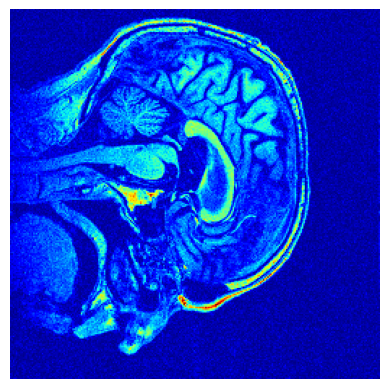

In [97]:

plt.imshow(mri_img.get_fdata()[:, :, mri_img.shape[2] // 2], cmap='jet')
plt.axis('off')
plt.show()